<a href="https://colab.research.google.com/github/MCalenda/Q-DELOREAN/blob/main/notebooks/w2v_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/SE4AI-Quantum/Q-DELOREAN

Mounted at /content/drive
/content/drive/MyDrive/SE4AI-Quantum/Q-DELOREAN


## Install Dependencies

In [2]:
!pip install codecarbon
! codecarbon init

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.1/174.1 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.6 MB/s eta 0:00:00

Welcome to CodeCarbon, here is your experiment id:
7250facd-1f0a-4e09-a0db-87797b13c69c (from ./.codecarbon.config)



## Import Libraries and Frameworks

In [3]:
import pandas as pd
import numpy as np


from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import np_utils

## Load data

In [4]:
DATASET_PATH = 'data/processed/promise-reclass_normalized.csv'
df = pd.read_csv(DATASET_PATH, index_col=False, nrows=None)

X_column = 'RequirementText'
y_column = 'Class'

X = df[X_column]
y = df[y_column]

## Encoding

In [5]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_one_hot = np_utils.to_categorical(y_encoded)

In [6]:
VECTOR_SIZE = 100
SEED = 42

X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=SEED)

sentences = [sentence.split() for sentence in X_train]
w2v_model = Word2Vec(sentences, vector_size=VECTOR_SIZE, seed=SEED)

In [7]:
def sentence_vector(sentence):
    vec = np.zeros(VECTOR_SIZE)
    num_words = 0
    for word in sentence:
        if word in w2v_model.wv.key_to_index:
            vec += w2v_model.wv.get_vector(word)
            num_words += 1
    if num_words > 0:
        vec /= num_words
    return vec

X_train_vectors = np.array([sentence_vector(sentence.split()) for sentence in X_train])
X_test_vectors = np.array([sentence_vector(sentence.split()) for sentence in X_test])

In [8]:
X_train_vectors[0]

array([ 3.93255628e-03,  6.51449501e-03, -3.91161739e-03, -3.28909484e-03,
       -3.38638318e-03,  4.97525407e-03, -3.31271486e-03,  7.57875125e-03,
       -8.44562409e-03, -3.67782468e-03, -5.36140765e-03,  5.20531333e-03,
        4.58524772e-03,  4.48697299e-03,  2.85542036e-03, -3.92249396e-04,
       -3.75158993e-03, -1.24736134e-02, -1.29314606e-03,  1.64944603e-03,
       -1.80129468e-03, -1.51412401e-03,  2.48267283e-03,  1.15514075e-03,
        6.77051750e-03, -7.14155176e-04, -1.80928013e-03,  2.68012984e-03,
       -5.47656108e-03, -5.40819112e-03,  1.66704104e-03, -7.29891995e-04,
       -3.17311380e-03, -2.22992647e-03,  8.15043786e-04, -9.07728259e-04,
        6.48342934e-03, -1.66948477e-03,  3.03137676e-03,  3.09776480e-03,
        2.41980189e-04,  2.13817941e-03,  4.48324077e-03, -3.93097452e-03,
       -2.64158778e-04,  1.32671552e-03, -1.68893341e-04,  4.55209945e-03,
        9.27967025e-03, -4.37881479e-03,  1.36911497e-03, -4.63609900e-03,
       -3.69775880e-03, -

## Training

### Define model

In [9]:
model = Sequential()
model.add(Dense(128, input_dim=VECTOR_SIZE, activation='relu'))
model.add(Dense(64, input_dim=VECTOR_SIZE, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, input_dim=VECTOR_SIZE, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
from keras.utils.layer_utils import count_params

trainable_count = count_params(model.trainable_weights)
non_trainable_count = count_params(model.non_trainable_weights)

In [11]:
trainable_count

23330

### Train model

In [12]:
EPOCHS = 50
BATCH_SIZE = 32

from codecarbon import EmissionsTracker
tracker = EmissionsTracker()
tracker.start()
model.fit(X_train_vectors, y_train, validation_data=(X_test_vectors, y_test), epochs=EPOCHS, batch_size=BATCH_SIZE)
tracker.stop()

[codecarbon INFO @ 15:08:35] [setup] RAM Tracking...
[codecarbon INFO @ 15:08:35] [setup] GPU Tracking...
[codecarbon INFO @ 15:08:35] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 15:08:35] [setup] CPU Tracking...
[codecarbon DEBUG @ 15:08:35] Not using PowerGadget, an exception occurred while instantiating IntelPowerGadget : Platform not supported by Intel Power Gadget
[codecarbon DEBUG @ 15:08:35] Not using the RAPL interface, an exception occurred while instantiating IntelRAPL : Intel RAPL files not found at /sys/class/powercap/intel-rapl on linux
[codecarbon WARNING @ 15:08:35] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 15:08:36] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 15:08:36] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 15:08:36] >>> Tracker's metadata:
[codecarbon INFO @ 15:08:36]   Platform system: Linux-5.15.107+

Epoch 1/50
12/12 [==============================] - 7s 24ms/step - loss: 0.6917 - accuracy: 0.5741 - val_loss: 0.6922 - val_accuracy: 0.5269
Epoch 2/50
12/12 [==============================] - 0s 7ms/step - loss: 0.6897 - accuracy: 0.5606 - val_loss: 0.6913 - val_accuracy: 0.5269
Epoch 3/50
12/12 [==============================] - 0s 6ms/step - loss: 0.6908 - accuracy: 0.5580 - val_loss: 0.6913 - val_accuracy: 0.5269
Epoch 4/50
12/12 [==============================] - 0s 6ms/step - loss: 0.6861 - accuracy: 0.5553 - val_loss: 0.6908 - val_accuracy: 0.5269
Epoch 5/50
12/12 [==============================] - 0s 6ms/step - loss: 0.6882 - accuracy: 0.5553 - val_loss: 0.6912 - val_accuracy: 0.5269
Epoch 6/50
12/12 [==============================] - 0s 6ms/step - loss: 0.6878 - accuracy: 0.5553 - val_loss: 0.6900 - val_accuracy: 0.5269
Epoch 7/50
12/12 [==============================] - 0s 6ms/step - loss: 0.6853 - accuracy: 0.5553 - val_loss: 0.6894 - val_accuracy: 0.5269
Epoch 8/50
12/12 [=

[codecarbon INFO @ 15:08:48] Energy consumed for RAM : 0.000092 kWh. RAM Power : 31.30528450012207 W
[codecarbon DEBUG @ 15:08:48] RAM : 31.31 W during 10.54 s [measurement time: 0.0012]
[codecarbon INFO @ 15:08:48] Energy consumed for all GPUs : 0.000161 kWh. Total GPU Power : 54.938 W
[codecarbon DEBUG @ 15:08:48] GPU : 54.94 W during 10.55 s [measurement time: 0.0054]
[codecarbon INFO @ 15:08:48] Energy consumed for all CPUs : 0.000125 kWh. Total CPU Power : 42.5 W
[codecarbon DEBUG @ 15:08:48] CPU : 42.50 W during 10.56 s [measurement time: 0.0010]
[codecarbon INFO @ 15:08:48] 0.000377 kWh of electricity used since the beginning.
[codecarbon DEBUG @ 15:08:48] last_duration=10.556922674179077
------------------------
[codecarbon DEBUG @ 15:08:48] We apply an energy mix of 489 g.CO2eq/kWh for Singapore
[codecarbon DEBUG @ 15:08:48] EmissionsData(timestamp='2023-06-15T15:08:48', project_name='codecarbon', run_id='79e743d6-5788-463f-9c6f-11c8e0efc5d9', duration=10.56053352355957, emiss

0.00018433661411061995

## Testing & Results

In [13]:
from sklearn.metrics import confusion_matrix, f1_score

predictions = model.predict(X_test_vectors)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

f1 = f1_score(true_classes, predicted_classes)
loss, accuracy = model.evaluate(X_test_vectors, y_test)

cm = confusion_matrix(true_classes, predicted_classes)

print("F1 Score:", f1)
print("Loss:", loss)
print("Accuracy:", accuracy)

3/3 [==============================] - 0s 4ms/step - loss: 0.4271 - accuracy: 0.8495
F1 Score: 0.8653846153846154
Loss: 0.42705315351486206
Accuracy: 0.8494623899459839


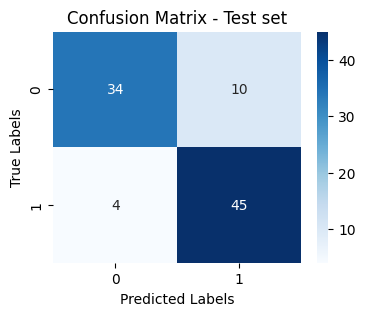

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix - Test set")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()